In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import transforms, utils

from sklearn.model_selection import train_test_split

import os as os

from tqdm import *

# Outline

Use the 5x5 base quadrants generated in the "Create Samples" notebook to train a neural network. This neural network will perform a regression analysis and predict the net Young's Modulus, E, of a material sample based on the 5x5 grid given to it. 

Currently, the network needs to have its dimensions manually changed if it were given anything except a 5x5 square input.

# Load Data

In [2]:
def load_file(fileE, fileI):
    
    # unpack the data
    Enet = np.load(fileE)
    sample_ind = np.load(fileI, allow_pickle=True)
    
    # parse file name for data
    name = fileE.split('.')[0]
    
    # get discretization of material quadrant
    dx = int(name[8:10])
    
    # number of samples
    N = int(name[14:])
    
    # Retrun matrices
    sample = np.zeros((N, 2*dx, 2*dx))
    sample_base = np.zeros((N, dx, dx))
    
    for i in range(sample_ind.shape[0]):
        ind = sample_ind[i]
        
        
        base = np.zeros(dx**2)
        base[ind] = 1
        base1 = base.reshape((dx, dx))
        base2 = np.flip(base1, axis=1)
        base3 = np.flip(base1, axis=0)
        base4 = np.flip(base2, axis=0)
        
        top = np.concatenate((base1, base2), axis=1)
        bott = np.concatenate((base3, base4), axis=1)
        layout = np.concatenate((top, bott), axis=0)
        
        sample_base[2*i] = base1
        sample[2*i] = layout
        
        sample_base[2*i+1] = np.flip(np.rot90(base1), axis=0)
        sample[2*i+1] = np.rot90(layout)
    
    
    
    return Enet, sample_base, sample

In [3]:
fileE = 'train_E_05x05_10000.npy'
fileI = 'train_I_05x05_10000.npy'

# Get data from files
'''
y = the training labels (Enet of each material)
x0 = training data (5x5) (the base design of each sample)
x1 = training data (10x10) (full binary layout of material microstructure)
'''
E, x0, x1 = load_file(fileE, fileI)


# Add dimensionality to the data
'''
Channel 1 = young's modulus
Channel 2 = poison's ratio
'''
E1 = 1000
v1 = .4
E2 = 100
v2 = .1

X0 = np.zeros((x0.shape[0], 2, x0.shape[1], x0.shape[2]))
X1 = np.zeros((x1.shape[0], 2, x1.shape[1], x1.shape[2]))

for i in range(x0.shape[0]):
    '''X0 DIMENSIONS'''
    A = np.zeros((x0.shape[1], x0.shape[2]))
    
    # Input young's modulus
    A[x0[i]==0] = E1
    A[x0[i]==1] = E2
    
    X0[i, 0] = A
    
    # Input young's modulus
    A[x0[i]==0] = v1
    A[x0[i]==1] = v2
    
    X0[i, 1] = A
    
    '''X1 DIMENSIONS'''
    B = np.zeros((x1.shape[1], x1.shape[2]))
    
    # Input young's modulus
    B[x1[i]==0] = E1
    B[x1[i]==1] = E2
    
    X1[i, 0] = B
    
    # Input young's modulus
    B[x1[i]==0] = v1
    B[x1[i]==1] = v2
    
    X1[i, 1] = B

# Neural Network Architecture

In [4]:
class Regdx(nn.Module):
    
    # Network consruction
    def __init__(self, in_channels, ngpu=1):
        super(Regdx, self).__init__()
        self.ngpu = ngpu
        
        # Convolutional 2D layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=10, kernel_size=3, padding=1), # 2 x 5 x 5
            nn.ReLU(),
            nn.BatchNorm2d(10), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 25, kernel_size=3), 
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Conv2d(25, 50, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        
        # Linear layers
        self.lin = nn.Sequential(
            nn.Linear(50, 20), 
            nn.ReLU(),
            nn.BatchNorm1d(20), 
            nn.Dropout(p=0.5),
            nn.Linear(20, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.ReLU()
        )
       
        
    def forward(self, x):
        x = self.conv(x)
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        x = self.lin(x)
        return x

# Train Network

In [5]:
# Select which data to train and normalize them
x = np.zeros(X0.shape)
x[:, 0, :, :] = X0[:, 0, :, :]/max(E1, E2)
x[:, 1, :, :] = X0[:, 1, :, :]/max(v1, v2)
y = (E/max(E1, E2)).reshape((x.shape[0], 1))

# Group the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
(X_train, X_test, y_train, y_test) = (torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_train).float(), torch.from_numpy(y_test).float())
dataset = TensorDataset(X_train,y_train)

# Batch
B = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=B, shuffle=True)

# Initiatlize model
model = Regdx(x.shape[1])

# Save model
model_store_path = os.getcwd()+'/GAN_Models'+'/Reg.pt'

# Loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
epochs = 1000
error = []
it = []

for i in tqdm(range(epochs)):
    for data in dataloader:
        x_tr = data[0]
        y_tr = data[1]
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x_tr)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_tr)

        # optimize the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    if i%20 == 19:
        it.append(i)
        error.append(loss.item())
        
        
torch.save(model.state_dict(), model_store_path)
model.eval()

100%|██████████| 1000/1000 [42:37<00:00,  2.61s/it]


Regdx(
  (conv): Sequential(
    (0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(10, 25, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=20, out_features=4, bias=True)


Text(0.5, 1.0, 'Accuracy of Results')

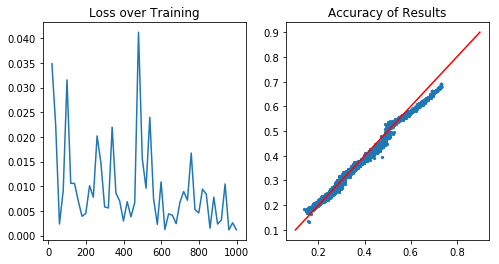

In [7]:
# Asses testing data
y_net = model(X_test)

# Plot Results of Neural Network
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

ax0.plot(it, error)
ax0.set_title('Loss over Training')

ax1.scatter(y_test.numpy(), y_net.detach().numpy(), s=3)
ax1.plot([.1, .9], [.1, .9], color='r')
ax1.set_title('Accuracy of Results')

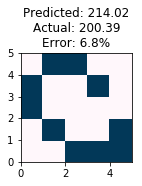

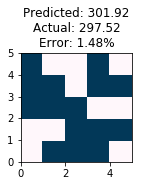

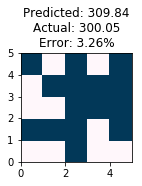

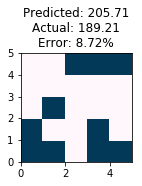

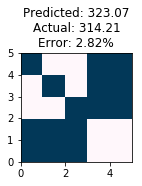

In [8]:
trials = 5
trial_i = np.random.randint(X_test.shape[0], size=trials)

for i in trial_i:
    plt.figure(figsize=(2, 2))
    plt.pcolormesh(X_test[i, 0].numpy(), cmap='PuBu')
    
    yn = round(y_net.detach().numpy()[i, 0]*max(E1, E2), 2)
    yt = round(y_test.numpy()[i, 0]*max(E1, E2), 2)
    err = round(abs(yn-yt)/yt*100, 2)
    
    p_title=plt.title('Predicted: '+ str(yn)+ '\nActual: ' + str(yt)+'\nError: '+str(err)+'%')